# 如何将pyg和fastai结合起来呢？

### 引入库区

In [69]:
from fastai import *
from fastai.basic_data import *
from fastai.torch_core import *
from fastai.data_block import *
from fastai.data_block import PreProcessors
import torch_geometric
import torch
from fastai.basic_train import *

import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool, JumpingKnowledge
from torch_geometric.datasets import TUDataset

### 自己写的函数区

In [70]:
# 定义自己的网络模型
class GCN(torch.nn.Module):
    def __init__(self, dataset, num_layers, hidden):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(GCNConv(hidden, hidden))
        self.lin1 = Linear(hidden, hidden)
        self.lin2 = Linear(hidden, dataset.num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        for conv in self.convs:
            x = F.relu(conv(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

### 试验区

数据下载

In [7]:
dataset = TUDataset('./', 'MUTAG')

Extracting ./MUTAG.zip
Processing...
Done!


In [8]:
dataset

MUTAG(188)

In [9]:
dataset[0]

Data(edge_attr=[38, 4], edge_index=[2, 38], x=[17, 7], y=[1])

In [110]:
"""
@Time    :2019/12/22 11:44
@Author  : 梁家熙
@Email:  :11849322@mail.sustech.edu.cn
"""
import json
import networkx as nx
from fastai.data_block import PreProcessors
from fastai.vision import Image, open_image
from torch_geometric.data import Data
from tqdm import tqdm
import random
from pprint import pprint
import os
import collections
from typing import List, Dict, Tuple
import logging
from fastai import *
from fastai.basic_data import *
from fastai.torch_core import *
from fastai.data_block import *
import torch_geometric
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
import torch
import matplotlib.image as mpimg # mpimg 用于读取图片


class MyBatch(torch_geometric.data.Batch):
    def to(self, device, **kwargs):
        t = self.apply(lambda x: x.to(device))
        return t


class GraphDataBunch(DataBunch):
    @classmethod
    def create(cls, train_ds:Dataset, valid_ds:Dataset, test_ds:Optional[Dataset]=None, path:PathOrStr='.', bs:int=64,
               val_bs:int=None, num_workers:int=defaults.cpus, dl_tfms:Optional[Collection[Callable]]=None,
               device:torch.device=None, collate_fn:Callable=data_collate, no_check:bool=False, **dl_kwargs) ->'DataBunch':
        "Create a `DataBunch` from `train_ds`, `valid_ds` and maybe `test_ds` with a batch size of `bs`. Passes `**dl_kwargs` to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        dls = [torch_geometric.data.DataLoader(d, b, shuffle=s) for d,b,s in
               zip(datasets, (bs,val_bs,val_bs,val_bs), (True,False,False,False)) if d is not None]
        return cls(*dls, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)

    # def one_batch(self, ds_type:DatasetType=DatasetType.Train, detach:bool=True, denorm:bool=True, cpu:bool=True)->Collection[Tensor]:
    #     "Get one batch from the data loader of `ds_type`. Optionally `detach` and `denorm`."
    #     x, y = zip(*self.train_ds[:64])
    #
    #     if detach: x,y = to_detach(x,cpu=cpu),to_detach(y,cpu=cpu)
    #     norm = getattr(self,'norm',False)
    #     if denorm and norm:
    #         x = self.denorm(x)
    #         if norm.keywords.get('do_y',False): y = self.denorm(y, do_x=True)
    #     return x,y

    def show_batch(self, rows:int=5, ds_type:DatasetType=DatasetType.Train, reverse:bool=False, **kwargs)->None:
        "Show a batch of data in `ds_type` on a few `rows`."
        x,y = self.one_batch(ds_type, True, True)

        if reverse: x,y = x.flip(0),y.flip(0)
        n_items = rows **2 if self.train_ds.x._square_show else rows
        if self.dl(ds_type).batch_size < n_items: n_items = self.dl(ds_type).batch_size
        x = x.to_data_list()

        xs = [self.train_ds.x.reconstruct(x[i]) for i in range(n_items)]
        #TODO: get rid of has_arg if possible
        if has_arg(self.train_ds.y.reconstruct, 'x'):
            ys = [self.train_ds.y.reconstruct(grab_idx(y, i), x=x) for i,x in enumerate(xs)]
        else : ys = [self.train_ds.y.reconstruct(y[i].data) for i in range(n_items)]
        self.train_ds.x.show_xys(xs, ys, **kwargs)

class GraphList(ItemList):
    _bunch = GraphDataBunch
    def __init__(self, items: Iterator, path: PathOrStr = '.', label_cls: Callable = None, inner_df: Any = None,
                 processor: PreProcessors = None, x: 'ItemList' = None, ignore_empty: bool = False):
        self.path = Path(path)
        self.num_parts = len(self.path.parts)
        self.items, self.x, self.ignore_empty = items, x, ignore_empty
        # if not isinstance(self.items, np.ndarray): self.items = array(self.items, dtype=object)
        self.label_cls, self.inner_df, self.processor = ifnone(label_cls, self._label_cls), inner_df, processor
        self._label_list, self._split = LabelList, ItemLists
        self.copy_new = ['x', 'label_cls', 'path']
        # self.items = array([(w) for w in self.items])

    def split_none(self):
        return self._split(self.path, self, ItemList([], ignore_empty=True))

    def reconstruct(self, t:Tensor, x:Tensor=None):
        edges = list([(a.item(), b.item()) for a, b in zip(t.edge_index[0], t.edge_index[1])])
        G = nx.DiGraph()
        G.add_edges_from(
            edges)
        G = G.to_undirected()
        pos = nx.spring_layout(G, seed=0)
        nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'),
                               node_color='b',
                               alpha=0.3,
                               node_size=500)

        nx.draw_networkx_labels(G, pos)
        nx.draw_networkx_edges(G, pos,
                               edge_color='gray',
                               # edge_cmap=plt.cm.Blues,
                               # edge_cmap=plt.get_cmap(),
                               alpha=0.8,
                               width=0.2,
                               # arrows=True,
                               )
        img = plt.savefig('t.png')
        # (640, 4, 480)
        img = open_image('t.png')

        plt.close()
        return img

    def show_xys(self, xs, ys, figsize: Tuple[int, int] = (9, 10), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows, rows, figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, figsize: Tuple[int, int] = None, **kwargs):
        """Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`.
        `kwargs` are passed to the show method."""
        figsize = ifnone(figsize, (6, 3 * len(xs)))
        fig, axs = plt.subplots(len(xs), 2, figsize=figsize)
        fig.suptitle('Ground truth / Predictions', weight='bold', size=14)
        for i, (x, y, z) in enumerate(zip(xs, ys, zs)):
            x.show(ax=axs[i, 0], y=y, **kwargs)
            x.show(ax=axs[i, 1], y=z, **kwargs)
            
    def split_by_rand_pct(self, valid_pct:float=0.2, seed:int=None)->'ItemLists':
        "Split the items randomly by putting `valid_pct` in the validation set, optional `seed` can be passed."
        if valid_pct==0.: return self.split_none()
        if seed is not None: np.random.seed(seed)
        rand_idx = torch.tensor(np.random.permutation(range_of(self))).long()
        cut = int(valid_pct * len(self))
        assert isinstance(rand_idx, torch.Tensor)
        return self.split_by_idx(rand_idx[:cut])

    def split_by_idx(self, valid_idx:Collection[int])->'ItemLists':
        "Split the data according to the indexes in `valid_idx`."
        #train_idx = [i for i in range_of(self.items) if i not in valid_idx]
        train_idx = torch.tensor(np.setdiff1d(arange_of(self.items), valid_idx)).long()
        return self.split_by_idxs(train_idx, valid_idx)
# class GraphDataBunch(DataBunch):
class GraphLearner(Learner):
    
    def show_results(self, ds_type=DatasetType.Valid, rows:int=5, **kwargs):
        "Show `rows` result of predictions on `ds_type` dataset."
        #TODO: get read of has_arg x and split_kwargs_by_func if possible
        #TODO: simplify this and refactor with pred_batch(...reconstruct=True)
        n_items = rows ** 2 if self.data.train_ds.x._square_show_res else rows
        if self.dl(ds_type).batch_size < n_items: n_items = self.dl(ds_type).batch_size
        ds = self.dl(ds_type).dataset
        self.callbacks.append(RecordOnCPU())
        preds = self.pred_batch(ds_type)
        *self.callbacks,rec_cpu = self.callbacks
        x,y = rec_cpu.input,rec_cpu.target
        norm = getattr(self.data,'norm',False)
        if norm:
            x = self.data.denorm(x)
            if norm.keywords.get('do_y',False):
                y     = self.data.denorm(y, do_x=True)
                preds = self.data.denorm(preds, do_x=True)
        analyze_kwargs,kwargs = split_kwargs_by_func(kwargs, ds.y.analyze_pred)
        x = x.to_data_list()
        preds = [ds.y.analyze_pred(grab_idx(preds, i), **analyze_kwargs) for i in range(n_items)]
        xs = [ds.x.reconstruct(x[i]) for i in range(n_items)]
        if has_arg(ds.y.reconstruct, 'x'):
            ys = [ds.y.reconstruct(grab_idx(y, i), x=x) for i,x in enumerate(xs)]
            zs = [ds.y.reconstruct(z, x=x) for z,x in zip(preds,xs)]
        else :
            ys = [ds.y.reconstruct(grab_idx(y, i)) for i in range(n_items)]
            zs = [ds.y.reconstruct(z) for z in preds]
        ds.x.show_xyzs(xs, ys, zs, **kwargs)

In [111]:
"""
@Time    :2019/12/22 12:04
@Author  : 梁家熙
@Email:  :11849322@mail.sustech.edu.cn
"""
import json

from fastai.basic_train import Learner
from tqdm import tqdm
import random
from pprint import pprint
import os
import collections
from typing import List, Dict, Tuple
import logging
import torch
import os.path as osp
from fastai.data_block import PreProcessors
from torch_geometric.data import Data
from tqdm import tqdm
import random
from pprint import pprint
import os
import collections
from typing import List, Dict, Tuple
import logging
from fastai import *
from fastai.basic_data import *
from fastai.torch_core import *
from fastai.data_block import *
import torch_geometric
import torch

from torch_geometric.datasets import TUDataset
from torch_geometric.utils import degree
import torch_geometric.transforms as T
import urllib
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

class NormalizedDegree(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        deg = degree(data.edge_index[0], dtype=torch.float)
        deg = (deg - self.mean) / self.std
        data.x = deg.view(-1, 1)
        return data

def get_dataset(name, myown = False, sparse=True):

    # 满足TUDataset接口的数据
    dataset = TUDataset('./', name)


    assert dataset is not None and len(dataset) != 0
    # 边属性 为NOne
    dataset.data.edge_attr = None

    # x属性是什么
    if dataset.data.x is None:
        max_degree = 0
        degs = []
        for data in dataset:
            # 列表添加
            degs += [degree(data.edge_index[0], dtype=torch.long)]
            max_degree = max(max_degree, degs[-1].max().item())

        # 最大度小于 1000 时
        if max_degree < 1000:
            # 转换成onehot形式
            dataset.transform = T.OneHotDegree(max_degree)
        else:
            deg = torch.cat(degs, dim=0).to(torch.float)
            mean, std = deg.mean().item(), deg.std().item()
            dataset.transform = NormalizedDegree(mean, std) # 标准化


    # 如果是 []对的形式,则转换成 adj的形式
    if not sparse:
        num_nodes = max_num_nodes = 0
        for data in dataset:
            num_nodes += data.num_nodes
            max_num_nodes = max(data.num_nodes, max_num_nodes)

        # Filter out a few really large graphs in order to apply DiffPool.
        if name == 'REDDIT-BINARY':
            num_nodes = min(int(num_nodes / len(dataset) * 1.5), max_num_nodes)
        else:
            num_nodes = min(int(num_nodes / len(dataset) * 5), max_num_nodes) # 设置成了 28, 因为 max_num_nodes = 28

        indices = []
        for i, data in enumerate(dataset):
            # 找到那些数量小于 num_nodes的 图(存储index)
            if data.num_nodes <= num_nodes:
                indices.append(i)
        dataset = dataset[torch.tensor(indices)]

        if dataset.transform is None:
            dataset.transform = T.ToDense(num_nodes) # 将数据设置为dense 模式 这个变换很好玩,要记住.
        else:
            dataset.transform = T.Compose(
                [dataset.transform, T.ToDense(num_nodes)])

    return dataset



import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool, JumpingKnowledge


class GCN(torch.nn.Module):
    def __init__(self, dataset, num_layers, hidden):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(GCNConv(hidden, hidden))
        self.lin1 = Linear(hidden, hidden)
        self.lin2 = Linear(hidden, dataset.num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, data):

        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        for conv in self.convs:
            x = F.relu(conv(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

In [112]:
dataset = get_dataset('MUTAG')

data = GraphList(dataset)

In [113]:
data = data.split_by_rand_pct(0.3)
def func(x):
    return x.y.item()

data = data.label_from_func(func)
def fun(data_list):
    a, b = zip(*data_list)
    a = MyBatch.from_data_list(
            a, [])
    a.__class__ = MyBatch
    return a, torch.tensor([w.data for w in b]).long()
data = data.databunch(collate_fn=lambda data_list: fun(data_list))

In [114]:
model = GCN(dataset, 1, 16)
learner = GraphLearner(data, model)
learner.fit(10)

epoch,train_loss,valid_loss,time
0,0.700809,0.693907,00:00
1,0.696551,0.691743,00:00
2,0.694740,0.690098,00:00
3,0.687743,0.688591,00:00
4,0.684635,0.687515,00:00
5,0.682204,0.686536,00:00
6,0.680928,0.685718,00:00
7,0.677629,0.685097,00:00
8,0.674427,0.684589,00:00
9,0.671973,0.684248,00:00


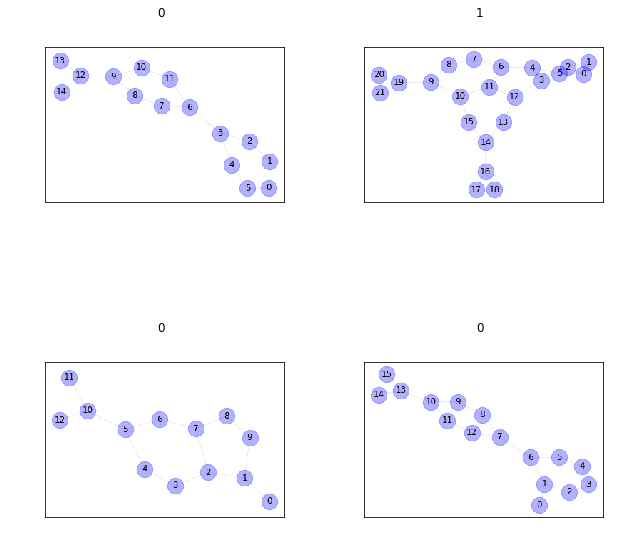

In [115]:
data.show_batch()

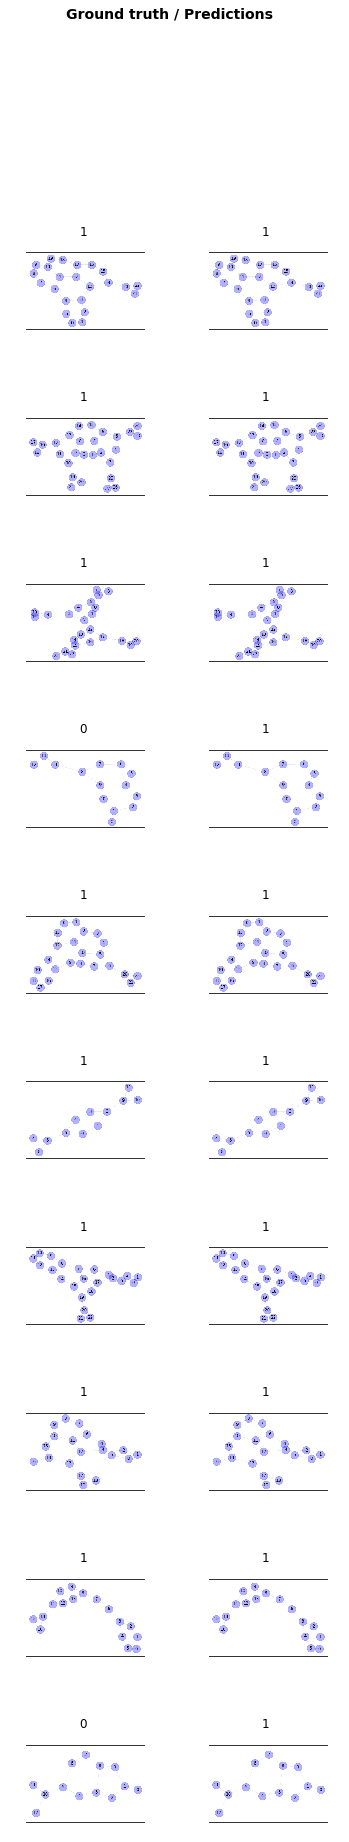

In [116]:
learner.show_results(ds_type=DatasetType.Train, rows = 10)

In [117]:
from fastai.train import Interpretation
a = Interpretation.from_learner(learner,DatasetType.Valid)

In [118]:
a.top_losses()

torch.return_types.topk(
values=tensor([0.8261, 0.8253, 0.8253, 0.8252, 0.8252, 0.8252, 0.8219, 0.8204, 0.8199,
        0.8187, 0.8184, 0.8183, 0.8177, 0.8176, 0.8176, 0.8167, 0.8159, 0.8153,
        0.8140, 0.8134, 0.8125, 0.8120, 0.8106, 0.8098, 0.8085, 0.5907, 0.5837,
        0.5831, 0.5830, 0.5811, 0.5811, 0.5802, 0.5784, 0.5783, 0.5780, 0.5766,
        0.5764, 0.5764, 0.5757, 0.5754, 0.5753, 0.5745, 0.5740, 0.5740, 0.5732,
        0.5732, 0.5732, 0.5731, 0.5731, 0.5731, 0.5719, 0.5719, 0.5719, 0.5719,
        0.5719, 0.5719]),
indices=tensor([41, 20, 25, 49, 19, 21, 48, 11, 47, 31, 28, 32, 35, 23, 30, 53, 14, 15,
        42, 54, 33, 18, 10,  9, 22, 46,  5, 55, 34,  1, 24,  3, 45, 26, 13,  4,
        17, 39, 27,  6,  8,  7, 12, 50,  0, 43, 52, 29, 51, 38, 36, 44, 37, 40,
         2, 16]))